# Iterative algorithm for Diffractive Optical Elements (DOEs) design based on Chirped Z-Transform algoritm



The design of DOEs is normally developed using Iterative Fourier Transform Analysis (IFTA). 

Problems: 

- The algorithm is based on the FFT, thus the intensity distribution is at the far field.
    
- The number of points in the mask and the observation plan is the same. Then, there are resolution in the observation plane may not be accurate for very small areas (at the focus) or very big areas.
  
To overcome theses problems, Hu Y. et al. [1] proposed the use of Chirped Z-Transform algorithm for the design of DOES. This algorithm presents the following advantages:

- The size and number of pixels is different for the mask and the observation plane. This allows to have a target with different size and resolution that the mask.
    
**Here, let us see several examples for the near and far field.**

References:

1. Hu Y. et al. "Efficient full-path optical calculation of scalar and vector diffraction using the Bluestein method" Light: Science & Applications  9(119) (2020)





## Algorithm design 



In [72]:
from diffractio import np, plt
from diffractio import um, nm, mm
from diffractio.diffractio import Diffractio
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY

In [73]:
# Iterative algorithm based on CZT

def IFTA_CZT(source: None | Scalar_field_XY, target: Scalar_mask_XY, z_obs: float, 
             num_steps: int, has_draw: bool = False):
    """Iterative algorithm based on the Chirped z_transform.

    Parameters:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        z_obs (float): distance to the observation plane
        num_steps (int): number of steps in the algorithm
        has_draw (bool): If True, draws the errors.

    Returns:
        mask_final (Scalar_mask_XY): Result mask of algorithm.
        DOE (Scalar_mask_XY):
        errors (np.array): Data of errors
    """
    wavelength = target.wavelength

    errors = np.zeros(num_steps)

    xout = target.x
    yout = target.y
    num_x_out = len(xout)
    num_y_out = len(yout)

    xin = source.x
    yin = source.y

    frame_in = dict(x=xin, y=yin, wavelength=wavelength)
    frame_out = dict(x=xout, y=yout, wavelength=wavelength)

    DOE = Diffractio('scalar', 'mask', **frame_in)
    u_z = Diffractio('scalar', 'mask', **frame_out)

    target_abs = np.abs(target.u)
    I_target = target_abs**2
    u_z.u = target_abs * np.exp(
        1j * 2 * np.pi * np.random.rand(num_y_out, num_x_out))
    I_result = target_abs**2
    I_result_mean = I_result.mean()

    for i in range(num_steps):
        print("{}/{}".format(i, num_steps), end='\r')
        DOE = u_z.CZT(z=-z_obs, xout=xin, yout=yin)
        mask = np.angle(DOE.u)
        DOE.u = np.exp(1j * mask)
        DOE = DOE*source
        field_z = DOE.CZT(z=z_obs, xout=xout, yout=yout)
        I_z = np.abs(field_z.u)**2
        I_z = I_z * I_result_mean / I_z.mean()
        u_z.u = target_abs * np.exp(1j * np.angle(field_z.u))

        error = nmse(I_target, I_z)
        print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
        errors[i] = error

    if has_draw:
        plt.figure()
        plt.imshow(I_result)
        plt.colorbar()
        plt.figure()
        plt.imshow(I_z)
        plt.colorbar()

        plt.figure()
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    mask = (mask + np.pi) / (2 * np.pi)

    mask_final = Diffractio('scalar','mask', **frame_in)
    mask_final.u = mask

    return mask_final, DOE, errors

In [74]:

# Efficiency of the algoritm, comparing the intensity at the observation plane and the target.

def nmse(I_result, I_target):
    """
    Computer the error as the average difference of the absolute value between of the intensity at target and the intensity at the result.

    Parameters:
        I_result (numpy.array): intensity produced by the algorithms
        I_target (numpy.array): intentisty at target
        is_balanced (bool): If True, perform the comparison using a proportion parameter to avoid different intensity levels

    Reference:
        K. Jahn and N. Bokor, “Intensity control of the focal spot by vectorial beam shaping,” Opt. Commun., vol. 283, no. 24, pp. 4859–4865, 2010, doi: 10.1016/j.optcom.2010.07.030.
        Similar to Ec. 17

    Returns:
        error: Mean difference between result and target.

    """

    error = np.sqrt(
        ((I_result / I_result.mean() - I_target / I_target.mean())**2).mean())

    return error

In [75]:
# Percentage of intensity at the target

def intensity_in_target(target, result, verbose=True):
    """
    Compute the intensity in the target plane.

    Parameters:
        target (Scalar_mask_XY): Target mask.
        result (Scalar_mask_XY): Result mask.

    Returns:
        intensity (np.array): Intensity in the target plane.
    """

    intensity_target = target.intensity()
    intensity_result_all = result.intensity()
    intensity_result = (target*result).intensity()

    percentage = intensity_result.sum() / intensity_result_all.sum()

    if verbose:
        print("percentage in target: {:2.2f} %".format(percentage*100))


    return percentage

## Far field

In [108]:
# Parameters

wavelength = 650*nm
z_obs = 500*mm


mask_size = 1.5*mm
pixel_size = 2*um


obs_size = 50*mm

num_mask = int(mask_size/pixel_size)
num_obs = 512


print("num pixels mask = {}".format(num_mask))

num pixels mask = 750


In [109]:
xin = np.linspace(-mask_size/2, mask_size/2, num_mask)
yin = np.linspace(-mask_size/2, mask_size/2, num_mask)

xout = np.linspace(-obs_size/2, obs_size/2, num_obs)
yout = np.linspace(-obs_size/2, obs_size/2, num_obs)

In [110]:
frame_in = dict(x=xin, y=yin, wavelength=wavelength)
frame_out = dict(x=xout, y=yout, wavelength=wavelength)

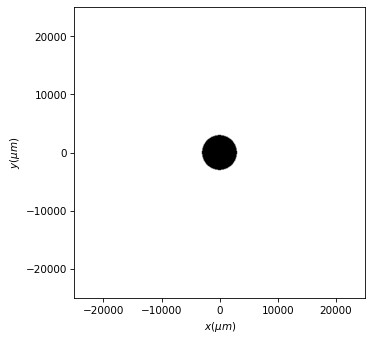

In [111]:
# mask to remove zero order

spot = Diffractio('scalar', 'mask', **frame_out)
spot.circle(r0=(0*mm,0), radius=3*mm)
spot.inverse_amplitude()
spot.draw()


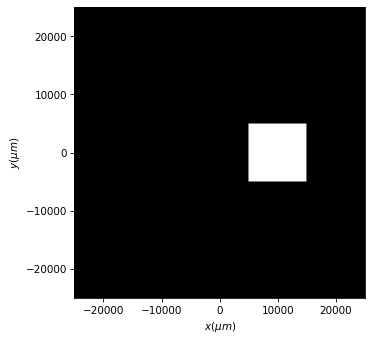

In [112]:
# Definition of target

target = Diffractio('scalar', 'mask', **frame_out)
target.square(r0=(10*mm,0), size=10*mm)
target.draw()


In [113]:
# Definition of source

source = Diffractio('scalar', 'source', **frame_in)
source.plane_wave()

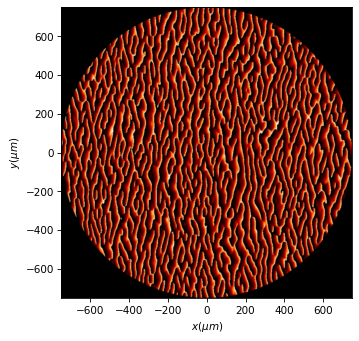

In [114]:
## Generation of mask

mask_final, DOE_final, errors = IFTA_CZT(source=source, target=target, z_obs=z_obs, num_steps=10, has_draw=False)
mask_final.pupil()
DOE_final.pupil()

mask_final.draw()

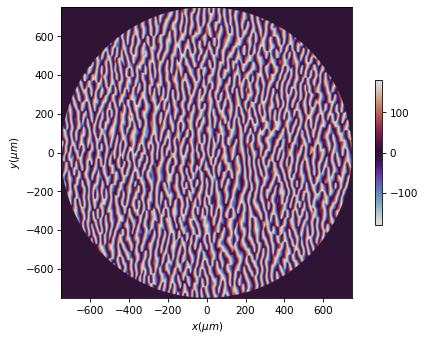

In [115]:
DOE_final.draw('phase', percentage_intensity=0.1, has_colorbar='vertical')

### Phase mask with continuous profile

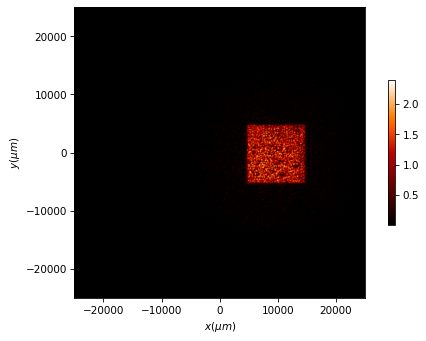

In [116]:
result_far = DOE_final.CZT(z=z_obs, xout=xout, yout=yout)
result_far.normalize()
result_far.draw('intensity', has_colorbar='vertical', logarithm=1e1)

In [117]:
# With this funciton we can check the percentage of intensity at the target.

intensity_in_target(target, result_far, verbose=True)


percentage in target: 87.07 %


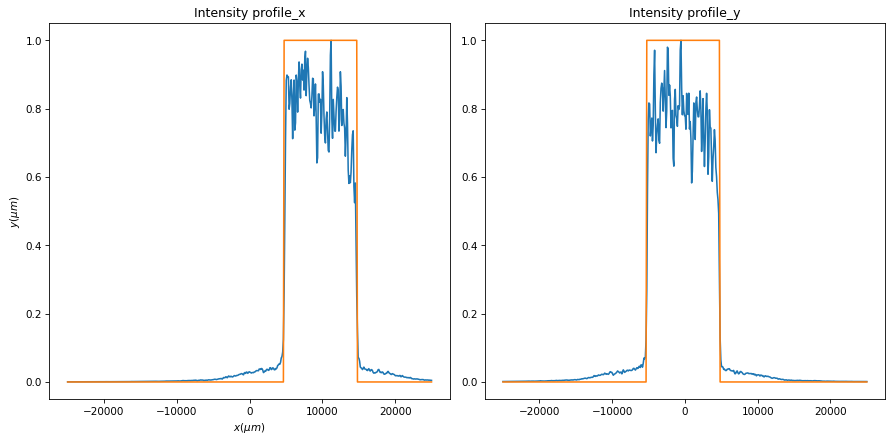

mask size: 9.98 mm, 9.98 mm


In [118]:
size_x, size_y = result_far.get_mask_size(threshold=0.25, has_draw=True, verbose=True)


### Phase mask with binary profile

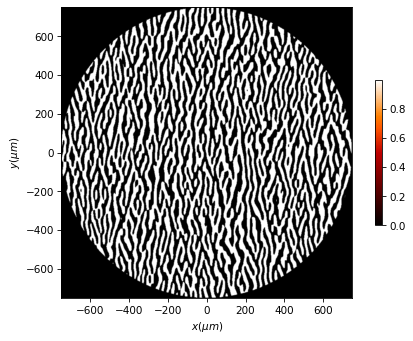

In [119]:
mask_final_binary = mask_final.duplicate()
mask_final_binary.binarize()
mask_final_binary.draw('intensity', has_colorbar='vertical', logarithm=0)

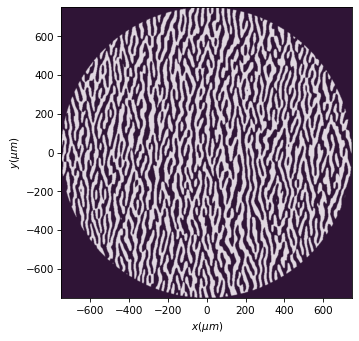

In [120]:
# Pass to phase mask 

DOE_phase_binary = DOE_final.duplicate()
DOE_phase_binary.u = np.exp(1j*np.pi*mask_final_binary.u)
DOE_phase_binary.draw('phase')

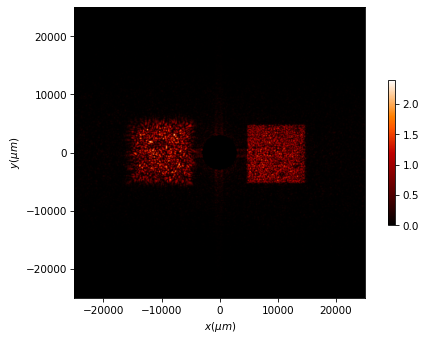

In [122]:
result_far_phase_binary = DOE_phase_binary.CZT(z=z_obs, xout=xout, yout=yout)

result_final = (result_far_phase_binary*spot)
result_final.normalize()
result_final.draw('intensity', has_colorbar='vertical', logarithm=1e1)


Although it is 'far field', the result is not purely symmetric, as we are not using the FFT, since CZT.

### Amplitude mask with binary profile

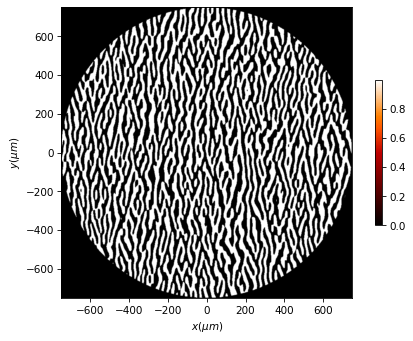

In [123]:
DOE_amplitude_binary = DOE_final.duplicate()
DOE_amplitude_binary.u =mask_final_binary.u
DOE_amplitude_binary.draw('intensity', has_colorbar='vertical', logarithm=0)


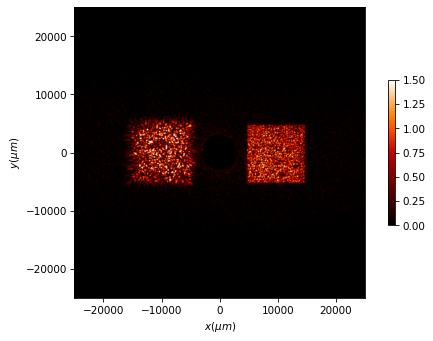

In [133]:

result_far_amplitude_binary = DOE_amplitude_binary.CZT(z=z_obs, xout=xout, yout=yout)
result_final = (result_far_amplitude_binary*spot)
result_final.normalize()
result_final.draw('intensity', has_colorbar='vertical', logarithm=1e1)
plt.clim(0,1.5)

In [92]:
# Diffractio also allows to save the mask in bmp format

DOE_amplitude_binary.save_mask("binary_mask.bmp")

## Near field with four focus

The CZT algorthm is also valid for the near field. We only need to change the observation distance.

In this first example, the target are four spots of light. Each spot is generated by a lens, and the algorithm interlaces them.

As se can see, the advantage of the algorithm is that the target and mask spaces can have different sizes, improving the performace.

In [93]:
wavelength = 650*nm
z_obs = 20*mm

mask_size = 2*mm
pixel_size = 5*um


obs_size = 500*um
num_mask = int(mask_size/pixel_size)
num_obs = 512


print("num pixels mask = {}".format(num_mask))

num pixels mask = 400


In [94]:
xin = np.linspace(-mask_size/2, mask_size/2, num_mask)
yin = np.linspace(-mask_size/2, mask_size/2, num_mask)

xout = np.linspace(-obs_size/2, obs_size/2, num_obs)
yout = np.linspace(-obs_size/2, obs_size/2, num_obs)

In [95]:
frame_in = dict(x=xin, y=yin, wavelength=wavelength)
frame_out = dict(x=xout, y=yout, wavelength=wavelength)

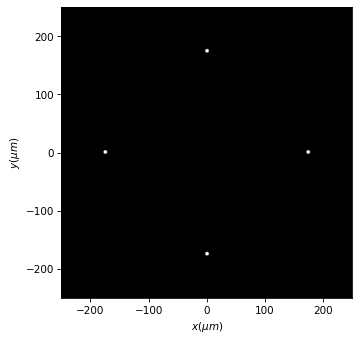

In [96]:
spot = Diffractio('scalar', 'mask', **frame_out)
spot.circle(r0=(0,0), radius=3*um)

size = 175*um
positions= np.array( [ [size,0] , [-size,0],  [0, -size], [0, size]])


target = Diffractio('scalar', 'mask', **frame_out)
target.photon_sieve(spot, positions)
target.draw()

In [97]:
mask_final, DOE_final, errors = IFTA_CZT(source=source, target=target, z_obs=z_obs, num_steps=10, has_draw=False)
mask_final.pupil()

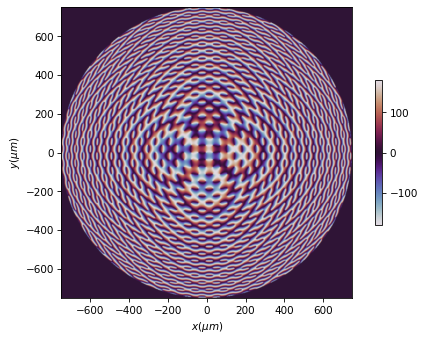

In [98]:
DOE_final.pupil()
DOE_final.draw('phase', percentage_intensity=0.1, has_colorbar='vertical')


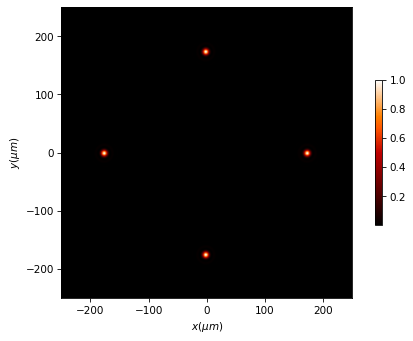

In [99]:

result_far = DOE_final.CZT(z=z_obs, xout=xout, yout=yout)
result_far.normalize()
result_far.draw('intensity', has_colorbar='vertical', logarithm=0)

## Near field with the same size

The algorithm is also valid for other kind of targets, also when target and observation plane have the same size but different number of pixels.

In [100]:
wavelength = 650*nm
z_obs = 25*mm

mask_size = 1.5*mm
pixel_size = 5*um


obs_size = mask_size

num_mask = int(mask_size/pixel_size)
num_obs = 500


print("num pixels mask = {}".format(num_mask))

num pixels mask = 300


In [101]:
xin = np.linspace(-mask_size/2, mask_size/2, num_mask)
yin = np.linspace(-mask_size/2, mask_size/2, num_mask)

xout = np.linspace(-obs_size/2, obs_size/2, num_obs)
yout = np.linspace(-obs_size/2, obs_size/2, num_obs)

In [102]:
frame_in = dict(x=xin, y=yin, wavelength=wavelength)
frame_out = dict(x=xout, y=yout, wavelength=wavelength)

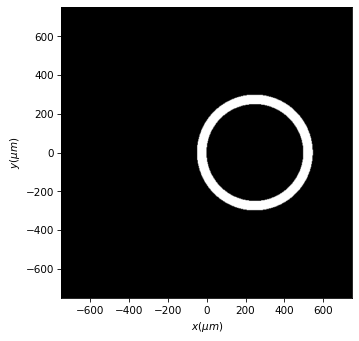

In [103]:

target = Diffractio('scalar', 'mask', **frame_out)
target.ring(r0=(250*um,0), radius1=250*um, radius2=299*um)
target.draw()


In [104]:
source = Diffractio('scalar', 'source', **frame_in)
source.plane_wave()

In [105]:
mask_final, DOE_final, errors = IFTA_CZT(source=source, target=target, z_obs=z_obs, num_steps=10, has_draw=False)


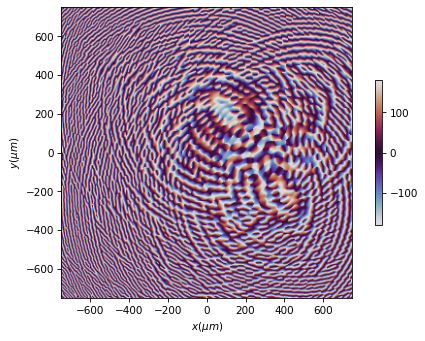

In [106]:
DOE_final.draw('phase', percentage_intensity=0.1, has_colorbar='vertical')


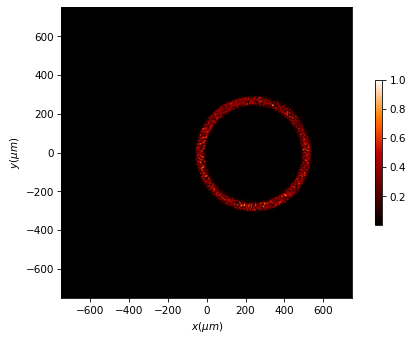

In [107]:

result_far = DOE_final.CZT(z=z_obs, xout=xout, yout=yout)
result_far.normalize()
result_far.draw('intensity', has_colorbar='vertical', logarithm=0)